# Uber Fare Prediction - (Comparing Best ML Models)

### Description: 
The project is about on world's largest taxi company Uber inc. In this project, we're looking to predict the fare for their future transactional cases. Uber delivers service to lakhs of customers daily. Now it becomes really important to manage their data properly to come up with new business ideas to get best results. Eventually, it becomes really important to estimate the fare prices accurately.

The datset contains the following fields:

#### key - a unique identifier for each trip
#### fare_amount - the cost of each trip in usd
#### pickup_datetime - date and time when the meter was engaged
#### passenger_count - the number of passengers in the vehicle (driver entered value)
#### pickup_longitude - the longitude where the meter was engaged
#### pickup_latitude - the latitude where the meter was engaged
#### dropoff_longitude - the longitude where the meter was disengaged
#### dropoff_latitude - the latitude where the meter was disengaged

# Objective:
Understand the Dataset & cleanup (if required).

Build Regression models to predict the fare price of uber ride.

Also evaluate the models & compare thier respective scores like R2, RMSE, etc.

# Stractegic Plan of Action:
#### We aim to solve the problem statement by creating a plan of action, Here are some of the necessary steps:

Data Exploration

Exploratory Data Analysis (EDA)

Data Pre-processing

Data Manipulation

Feature Selection/Extraction

Predictive Modelling

Project Outcomes & Conclusion

# 1. Data Exploration

In [8]:
#Importing the basic librarires

import os
import math
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import geopy.distance
from tqdm import tqdm
from IPython.display import display

from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

In [9]:
#Importing the dataset

df = pd.read_csv('uber_update.csv')

df.drop(['Unnamed: 0','key'], axis=1, inplace=True)
display(df.head())

target = 'fare_amount'
features = [i for i in df.columns if i not in [target]]

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2023-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2017-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2017-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2017-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2022-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5



Inference: The Datset consists of 7 features & 200000 samples.


In [10]:
#Check for empty elements

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)
df.dropna(inplace=True)

                   Total Null Values  Percentage
fare_amount                        0         0.0
pickup_datetime                    0         0.0
pickup_longitude                   0         0.0
pickup_latitude                    0         0.0
passenger_count                    0         0.0
dropoff_longitude                  1         0.0
dropoff_latitude                   1         0.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199999 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        199999 non-null  float64
 1   pickup_datetime    199999 non-null  object 
 2   pickup_longitude   199999 non-null  float64
 3   pickup_latitude    199999 non-null  float64
 4   dropoff_longitude  199999 non-null  float64
 5   dropoff_latitude   199999 non-null  float64
 6   passenger_count    199999 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 12.2+ MB


In [12]:
# Reframing the columns

df = df[(df.pickup_latitude<90) & (df.dropoff_latitude<90) &
        (df.pickup_latitude>-90) & (df.dropoff_latitude>-90) &
        (df.pickup_longitude<180) & (df.dropoff_longitude<180) &
        (df.pickup_longitude>-180) & (df.dropoff_longitude>-180)]

df.pickup_datetime=pd.to_datetime(df.pickup_datetime)

# Extracting temporal features:
df['year'] = df.pickup_datetime.dt.year
df['month'] = df.pickup_datetime.dt.month
df['weekday'] = df.pickup_datetime.dt.weekday
df['hour'] = df.pickup_datetime.dt.hour

# Creating categorical features for time intervals:
df['Monthly_Quarter'] = df.month.map({1:'Q1',2:'Q1',3:'Q1',4:'Q2',5:'Q2',6:'Q2',7:'Q3',
                                      8:'Q3',9:'Q3',10:'Q4',11:'Q4',12:'Q4'})
df['Hourly_Segments'] = df.hour.map({0:'H1',1:'H1',2:'H1',3:'H1',4:'H2',5:'H2',6:'H2',7:'H2',8:'H3',
                                     9:'H3',10:'H3',11:'H3',12:'H4',13:'H4',14:'H4',15:'H4',16:'H5',
                                     17:'H5',18:'H5',19:'H5',20:'H6',21:'H6',22:'H6',23:'H6'})

# Calculating distance between pickup and dropoff locations:
df['Distance']=[round(geopy.distance.distance((df.pickup_latitude[i], df.pickup_longitude[i]),(df.dropoff_latitude[i], df.dropoff_longitude[i])).m,2) for i in df.index]

# Dropping unnecessary columns:
df.drop(['pickup_datetime','month', 'hour',], axis=1, inplace=True)

original_df = df.copy(deep=True)

df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,Monthly_Quarter,Hourly_Segments,Distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2023,6,Q2,H5,1681.11
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2017,0,Q3,H6,2454.36
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2017,3,Q3,H6,5039.60
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2017,0,Q2,H3,1661.44
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2022,6,Q3,H5,4483.73


In [13]:
#Checking the dtypes of all the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199987 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        199987 non-null  float64
 1   pickup_longitude   199987 non-null  float64
 2   pickup_latitude    199987 non-null  float64
 3   dropoff_longitude  199987 non-null  float64
 4   dropoff_latitude   199987 non-null  float64
 5   passenger_count    199987 non-null  int64  
 6   year               199987 non-null  int64  
 7   weekday            199987 non-null  int64  
 8   Monthly_Quarter    199987 non-null  object 
 9   Hourly_Segments    199987 non-null  object 
 10  Distance           199987 non-null  float64
dtypes: float64(6), int64(3), object(2)
memory usage: 22.3+ MB


In [14]:
#Checking number of unique rows in each feature

df.nunique().sort_values()

Monthly_Quarter           4
Hourly_Segments           6
year                      7
weekday                   7
passenger_count           8
fare_amount            1240
pickup_longitude      70974
dropoff_longitude     76802
pickup_latitude       83692
dropoff_latitude      90453
Distance             164549
dtype: int64

In [15]:
#Checking number of unique rows in each feature

nu = df.drop([target], axis=1).nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df.drop([target], axis=1).shape[1]):
    if nu.values[i]<=24:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 5 numerical & 5 categorical features.


In [16]:
#Checking the stats of all the columns

display(df.describe())

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,Distance
count,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,1.999870e+05
mean,11.359849,-72.501786,39.917937,-72.511608,39.922031,1.684544,2019.742463,2.983444,2.056346e+04
std,9.901868,10.449955,6.130412,10.412192,6.117669,1.385999,1.856438,2.049118,3.796638e+05
min,-52.000000,-93.824668,-74.015515,-75.458979,-74.015750,0.000000,2017.000000,0.000000,0.000000e+00
25%,6.000000,-73.992064,40.734793,-73.991407,40.733823,1.000000,2018.000000,1.000000,1.215530e+03
50%,8.500000,-73.981822,40.752592,-73.980092,40.753042,1.000000,2020.000000,3.000000,2.121280e+03
75%,12.500000,-73.967154,40.767157,-73.963658,40.768000,2.000000,2021.000000,5.000000,3.874255e+03
max,499.000000,40.808425,48.018760,40.831932,45.031598,208.000000,2023.000000,6.000000,8.783594e+06


Inference: The stats seem to be fine, let us do further analysis on the Dataset

# 2. Exploratory Data Analysis (EDA)

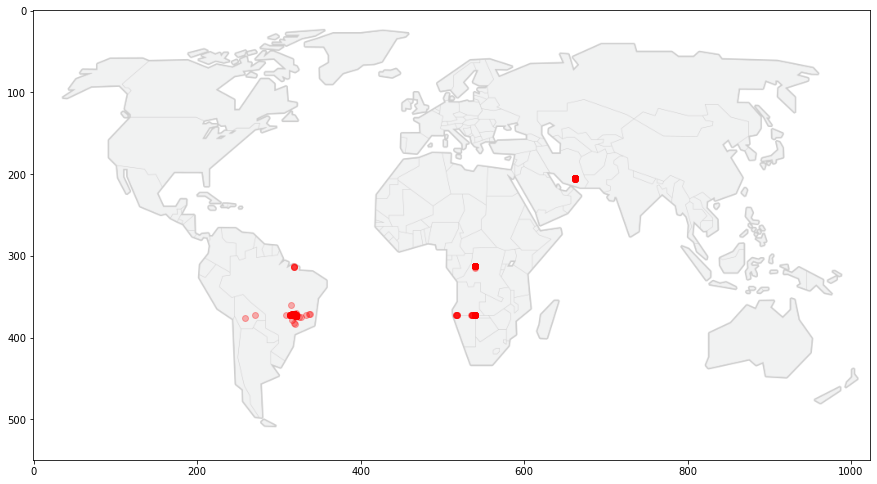

In [17]:
plt.figure(figsize=[15,10])
a=plt.imread('https://raw.githubusercontent.com/Masterx-AI/Project_Uber_Fare_Prediction/main/wm.png')
plt.imshow(a, alpha=0.2)
plt.scatter( (df.pickup_longitude+180)*3,(df.pickup_latitude+215)*1.45555555,alpha=0.3, color='red')
#mdf.plot(kind='scatter',x='pickup_latitude',y='pickup_longitude',alpha=0.1)
plt.show()

Overall, this code chunk creates a scatter plot of pickup locations overlaid on a map image fetched from a URL, providing a visual representation of the geographical distribution of pickup points.

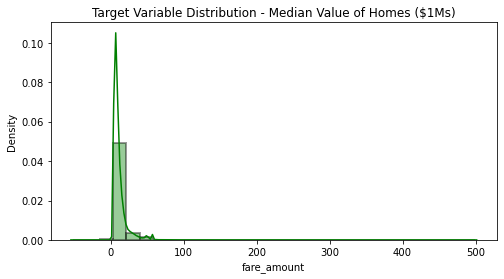

In [18]:
#Let us first analyze the distribution of the target variable

plt.figure(figsize=[8,4])
sns.distplot(df[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
plt.show()

### Inference:
The Target Variable seems to be be highly skewed, with most datapoints lieing near 0.

                               Visualising Categorical Features:                                


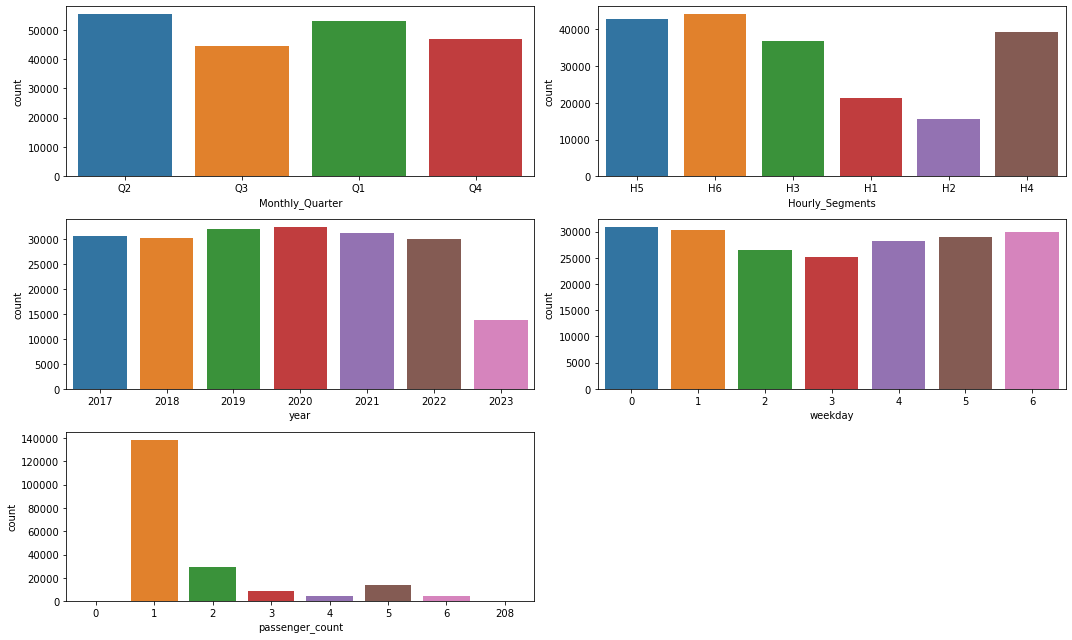

In [19]:
#Visualising the categorical features 

print('\033[1mVisualising Categorical Features:'.center(100))

n=2
plt.figure(figsize=[15,3*math.ceil(len(cf)/n)])



for i in range(len(cf)):
    if df[cf[i]].nunique()<=12:
        plt.subplot(math.ceil(len(cf)/n),n,i+1)
        sns.countplot(df[cf[i]])
    else:
        plt.subplot(3,1,i-3)
        sns.countplot(df[cf[i]])
     
        
plt.tight_layout()
plt.show()

#### Inference: 
The categorical features distribution can be seen in the above plots.

                                 Numeric Features Distribution                                  


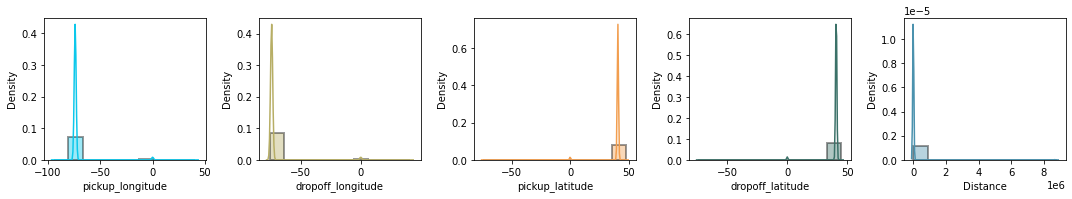

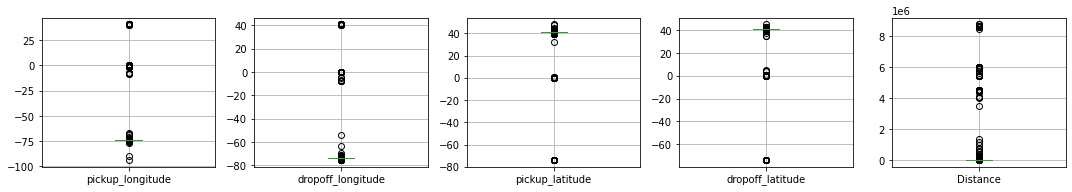

In [20]:
#Visualising the numeric features 

print('\033[1mNumeric Features Distribution'.center(100))

n=5

plt.figure(figsize=[15,5*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    sns.distplot(df[nf[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,5*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    df.boxplot(nf[i])
plt.tight_layout()
plt.show()

### Inference: 
There seem to be some outliers. let us fix these in the upcoming section...

# 3. Data Preprocessing

In [21]:
#Removal of any Duplicate rows (if any)

counter = 0
rs,cs = original_df.shape

df.drop_duplicates(inplace=True)
df.drop(['pickup_latitude','pickup_longitude',
         'dropoff_latitude','dropoff_longitude'],axis=1)

if df.shape==(rs,cs):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {rs-df.shape[0]}')


Inference: Number of duplicates dropped/fixed ---> 109


In [22]:
#Converting categorical Columns to Numeric

df1 = df.copy()
df3 = df1.copy()

ecc = nvc[nvc['Percentage']!=0].index.values
fcc = [i for i in cf if i not in ecc]
#One-Hot Binay Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1mOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2 and df3[i].nunique()<17):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)
        
df3.shape


Dummy Encoding on features:
Monthly_Quarter
Hourly_Segments
year
weekday
passenger_count


(199878, 33)

In [23]:
#Removal of outlier:

df1 = df3.copy()

#features1 = [i for i in features if i not in ['CHAS','RAD']]
features1 = nf

for i in features1:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
display(df1.head())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df3.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df1.shape[0]))

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance,Monthly_Quarter_Q2,Monthly_Quarter_Q3,Monthly_Quarter_Q4,Hourly_Segments_H2,...,weekday_4,weekday_5,weekday_6,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_208
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1681.11,1,0,0,0,...,0,0,1,1,0,0,0,0,0,0
1,7.7,-73.994355,40.728225,-73.994710,40.750325,2454.36,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,12.9,-74.005043,40.740770,-73.962565,40.772647,5039.60,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,5.3,-73.976124,40.790844,-73.965316,40.803349,1661.44,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,4.9,-73.969019,40.755910,-73.969019,40.755910,0.00,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0



Inference:
Before removal of outliers, The dataset had 199878 samples.
After removal of outliers, The dataset now has 163202 samples.


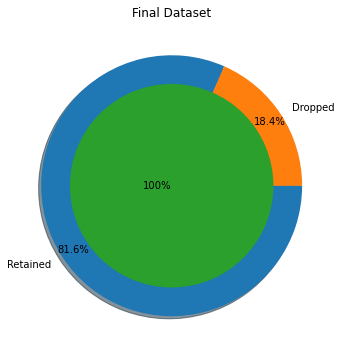


Inference: After the cleanup process, 36785 samples were dropped, while retaining 18.39% of the data.


In [24]:
#Final Dataset size after performing Preprocessing

df = df1.copy()
df.columns=[i.replace('-','_') for i in df.columns]

plt.title('Final Dataset')
plt.pie([df.shape[0], original_df.shape[0]-df.shape[0]], radius = 1, labels=['Retained','Dropped'], counterclock=False, 
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()

print(f'\n\033[1mInference:\033[0m After the cleanup process, {original_df.shape[0]-df.shape[0]} samples were dropped, \
while retaining {round(100 - (df.shape[0]*100/(original_df.shape[0])),2)}% of the data.')

# 4. Data Manipulation

In [25]:
#Splitting the data intro training & testing sets

m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_'))
    
df.columns = m
X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (163202, 32) (163202,) 
Training set  --->  (130561, 32) (130561,) 
Testing set   --->  (32641, 32)  (32641,)


In [26]:
#Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(100))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(100))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                               Standardardization on Training set                               


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance,Monthly_Quarter_Q2,Monthly_Quarter_Q3,Monthly_Quarter_Q4,Hourly_Segments_H2,Hourly_Segments_H3,...,weekday_4,weekday_5,weekday_6,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_208
count,1.305610e+05,1.305610e+05,1.305610e+05,1.305610e+05,1.305610e+05,1.305610e+05,1.305610e+05,1.305610e+05,1.305610e+05,1.305610e+05,...,1.305610e+05,1.305610e+05,1.305610e+05,1.305610e+05,1.305610e+05,1.305610e+05,1.305610e+05,1.305610e+05,1.305610e+05,1.305610e+05
mean,3.829547e-14,2.006273e-13,-1.303948e-13,2.535702e-13,1.511783e-16,4.826559e-16,-1.286809e-15,6.827564e-16,8.702947e-16,6.402518e-16,...,-2.854587e-15,1.571513e-15,1.498708e-15,-1.051029e-15,-2.459634e-15,-3.530550e-15,7.301839e-15,-2.144935e-15,-1.342104e-16,4.191868e-16
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,...,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-2.958444e+00,-2.894958e+00,-2.922049e+00,-2.871467e+00,-1.620130e+00,-6.148139e-01,-5.332011e-01,-5.551224e-01,-2.771293e-01,-4.874461e-01,...,-4.086750e-01,-4.162772e-01,-4.230432e-01,-1.501825e+00,-4.127377e-01,-2.171450e-01,-1.492782e-01,-2.739759e-01,-1.479862e-01,-2.767547e-03
25%,-6.797048e-01,-6.868089e-01,-6.715386e-01,-6.658898e-01,-7.639008e-01,-6.148139e-01,-5.332011e-01,-5.551224e-01,-2.771293e-01,-4.874461e-01,...,-4.086750e-01,-4.162772e-01,-4.230432e-01,-1.501825e+00,-4.127377e-01,-2.171450e-01,-1.492782e-01,-2.739759e-01,-1.479862e-01,-2.767547e-03
50%,-6.299513e-02,3.232532e-02,-6.478786e-02,5.017371e-02,-2.347137e-01,-6.148139e-01,-5.332011e-01,-5.551224e-01,-2.771293e-01,-4.874461e-01,...,-4.086750e-01,-4.162772e-01,-4.230432e-01,6.658564e-01,-4.127377e-01,-2.171450e-01,-1.492782e-01,-2.739759e-01,-1.479862e-01,-2.767547e-03
75%,6.421290e-01,6.557700e-01,6.179120e-01,6.356394e-01,5.660065e-01,1.626508e+00,-5.332011e-01,-5.551224e-01,-2.771293e-01,-4.874461e-01,...,-4.086750e-01,-4.162772e-01,-4.230432e-01,6.658564e-01,-4.127377e-01,-2.171450e-01,-1.492782e-01,-2.739759e-01,-1.479862e-01,-2.767547e-03
max,3.250606e+00,2.804203e+00,3.139085e+00,2.806310e+00,2.930237e+00,1.626508e+00,1.875465e+00,1.801404e+00,3.608424e+00,2.051509e+00,...,2.446932e+00,2.402245e+00,2.363825e+00,6.658564e-01,2.422847e+00,4.605218e+00,6.698900e+00,3.649956e+00,6.757385e+00,3.613309e+02



                                Standardardization on Testing set                                


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance,Monthly_Quarter_Q2,Monthly_Quarter_Q3,Monthly_Quarter_Q4,Hourly_Segments_H2,Hourly_Segments_H3,...,weekday_4,weekday_5,weekday_6,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_208
count,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,...,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,3.264100e+04
mean,-0.002168,0.001399,0.001209,0.003186,0.007260,0.000638,-0.003813,0.001142,-0.001911,0.001583,...,0.004518,-0.014236,-0.005367,0.005212,-0.000183,-0.006764,-0.008920,0.000354,-0.001379,-2.767547e-03
std,0.997609,0.995525,0.997139,1.006165,0.995376,1.000338,0.997446,1.000726,0.996825,1.001252,...,1.004599,0.985675,0.994779,0.997821,0.999831,0.985039,0.970323,1.000613,0.995448,1.324915e-15
min,-2.961011,-2.892176,-2.893846,-2.868806,-1.620130,-0.614814,-0.533201,-0.555122,-0.277129,-0.487446,...,-0.408675,-0.416277,-0.423043,-1.501825,-0.412738,-0.217145,-0.149278,-0.273976,-0.147986,-2.767547e-03
25%,-0.677600,-0.677935,-0.667209,-0.654651,-0.749688,-0.614814,-0.533201,-0.555122,-0.277129,-0.487446,...,-0.408675,-0.416277,-0.423043,-1.501825,-0.412738,-0.217145,-0.149278,-0.273976,-0.147986,-2.767547e-03
50%,-0.060929,0.044892,-0.064848,0.045174,-0.224593,-0.614814,-0.533201,-0.555122,-0.277129,-0.487446,...,-0.408675,-0.416277,-0.423043,0.665856,-0.412738,-0.217145,-0.149278,-0.273976,-0.147986,-2.767547e-03
75%,0.639968,0.647808,0.621941,0.650502,0.570707,1.626508,-0.533201,-0.555122,-0.277129,-0.487446,...,-0.408675,-0.416277,-0.423043,0.665856,-0.412738,-0.217145,-0.149278,-0.273976,-0.147986,-2.767547e-03
max,3.248602,2.797152,3.134454,2.804564,2.927538,1.626508,1.875465,1.801404,3.608424,2.051509,...,2.446932,2.402245,2.363825,0.665856,2.422847,4.605218,6.698900,3.649956,6.757385,-2.767547e-03


# 5. Feature Selection/Extraction

                                       Correlation Matrix                                       


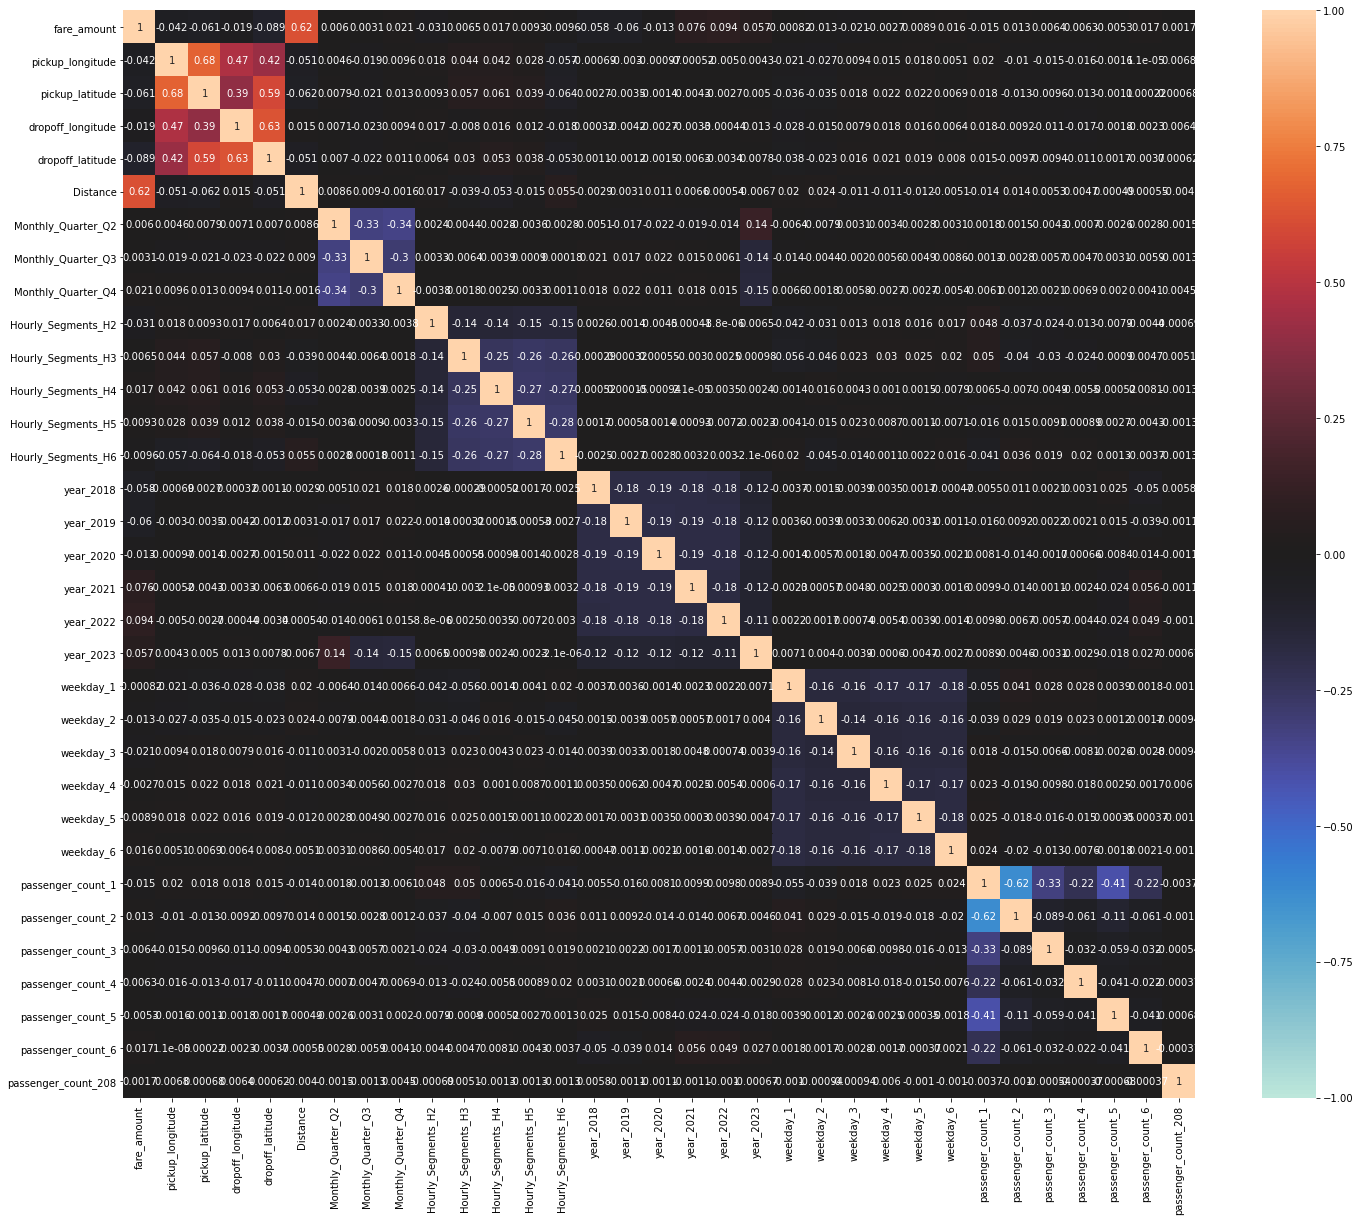

In [27]:
#Checking the correlation

print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[24,20])
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()

### Inference: 
There seems to be strong multi-correlation between the features. Let us try to fix these...

In [28]:
#Testing a Linear Regression model with statsmodels

Train_xy = pd.concat([Train_X,Train_Y.reset_index(drop=True)],axis=1)
a = Train_xy.columns.values

API = api.ols(formula='{} ~ {}'.format(target,' + '.join(i for i in Train_X.columns)), data=Train_xy).fit()
#print(API.conf_int())
#print(API.pvalues)
API.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     3519.
Date:                Mon, 11 Mar 2024   Prob (F-statistic):               0.00
Time:                        15:45:16   Log-Likelihood:            -3.3494e+05
No. Observations:              130561   AIC:                         6.699e+05
Df Residuals:                  130528   BIC:                         6.703e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1033.3740     84.765     12.191      0.000     867.236    1199.512
pickup_longitude        0.4966      0.793      0.626      0.531      -1.057       2.051
pickup_latitude         1.2747      0.655      1.946      0.052      -0.009       2.559
dropoff_longitude       4.8727      0.720      6.767      0.000       3.461       6.284
dropoff_latitude      -16.8244      0.596    -28.211      0.000     -17.993     -15.656
Distance                0.0021   6.51e-06    318.167      0.000       0.002       0.002
Monthly_Quarter_Q2      0.1462      0.024      6.181      0.000       0.100       0.193
Monthly_Quarter_Q3      0.2986      0.025     11.742      0.000       0.249       0.348
Monthly_Quarter_Q4      0.5002      0.025     19.996      0.000       0.451       0.549
Hourly_Segments_H2     -0.1939      0.044     -4.396      0.000      -0.280      -0.107
Hourly_Segments_H3      0.8324      0.036     23.242      0.000       0.762       0.903
Hourly_Segments_H4      1.0148      0.035     28.853      0.000       0.946       1.084
Hourly_Segments_H5      0.7348      0.035     21.141      0.000       0.667       0.803
Hourly_Segments_H6      0.1167      0.035      3.371      0.001       0.049       0.185
year_2018               0.1083      0.031      3.443      0.001       0.047       0.170
year_2019               0.0555      0.031      1.783      0.075      -0.005       0.116
year_2020               0.5174      0.031     16.674      0.000       0.457       0.578
year_2021               1.4824      0.031     47.244      0.000       1.421       1.544
year_2022               1.7276      0.032     54.550      0.000       1.666       1.790
year_2023               1.9046      0.041     46.535      0.000       1.824       1.985
weekday_1              -0.3190      0.032    -10.062      0.000      -0.381      -0.257
weekday_2              -0.5098      0.033    -15.300      0.000      -0.575      -0.444
weekday_3              -0.3406      0.033    -10.306      0.000      -0.405      -0.276
weekday_4              -0.1272      0.032     -3.978      0.000      -0.190      -0.065
weekday_5               0.0198      0.032      0.625      0.532      -0.042       0.082
weekday_6               0.0470      0.031      1.493      0.136      -0.015       0.109
passenger_count_1       0.1970      0.148      1.335      0.182      -0.092       0.486
passenger_count_2       0.3659      0.149      2.456      0.014       0.074       0.658
passenger_count_3       0.3609      0.153      2.361      0.018       0.061       0.661
passenger_count_4       0.4479      0.159      2.824      0.005       0.137       0.759
passenger_count_5       0.3169      0.151      2.101      0.036       0.021       0.613
passenger_count_6       0.2273      0.159      1.429      0.153      -0.084       0.539
pas

#### Inference: 
We can fix these multicollinearity with two techniques:

Manual Method - Variance Inflation Factor (VIF)

Automatic Method - Recursive Feature Elimination (RFE)

Feature Elmination using PCA Decomposition

# 5a. Manual Method - VIF

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [02:53<00:00,  5.60s/it]


Dropped Features -->  ['passenger_count_1', 'Hourly_Segments_H5', 'pickup_latitude', 'dropoff_longitude', 'year_2020', 'weekday_6', 'Monthly_Quarter_Q4', 'Hourly_Segments_H3', 'weekday_1', 'year_2022', 'pickup_longitude', 'year_2019', 'Monthly_Quarter_Q2', 'Hourly_Segments_H6', 'weekday_4']


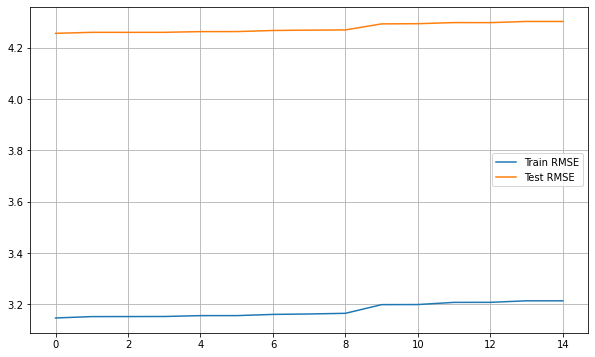

In [29]:
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]

DROP=[];b=[]

for i in tqdm(range(len(Train_X_std.columns)-1)):
    vif = pd.DataFrame()
    X = Train_X_std.drop(DROP,axis=1)
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    vif.reset_index(drop=True, inplace=True)
    if vif.loc[0][1]>=1.1:
        DROP.append(vif.loc[0][0])
        LR = LinearRegression()
        LR.fit(Train_X_std.drop(DROP,axis=1), Train_Y)

        pred1 = LR.predict(Train_X_std.drop(DROP,axis=1))
        pred2 = LR.predict(Test_X_std.drop(DROP,axis=1))
        
        Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
        Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))


        
print('Dropped Features --> ',DROP)


plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.75,20.75])
plt.legend()
plt.grid()
plt.show()

#### This chunk of code imports necessary libraries, initializes variables, and starts a loop to iterate over each column in the standardized training data. Inside the loop, it calculates the Variance Inflation Factor (VIF) for each feature to assess multicollinearity.

# 5b. Automatic Method - RFE

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [01:42<00:00,  3.29s/it]


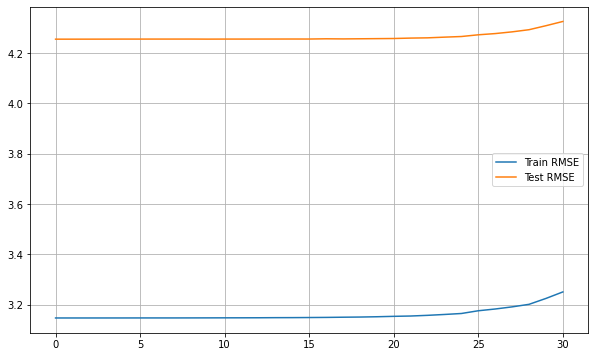

In [30]:
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)

m=df.shape[1]-2
for i in tqdm(range(m)):
    lm = LinearRegression()


    rfe = RFE(lm,n_features_to_select=Train_X_std.shape[1]-i)             # running RFE
    rfe = rfe.fit(Train_X_std, Train_Y)
    
  
    LR = LinearRegression()
    LR.fit(Train_X_std.loc[:,rfe.support_], Train_Y)
    


    pred1 = LR.predict(Train_X_std.loc[:,rfe.support_])
    pred2 = LR.predict(Test_X_std.loc[:,rfe.support_])

    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))
        


plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')

plt.legend()
plt.grid()
plt.show()

# 5c. Feature Elmination using PCA Decomposition

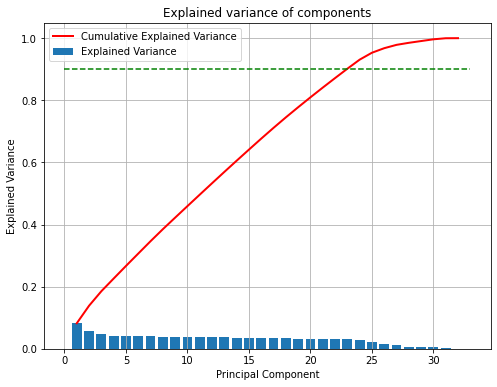

In [31]:
from sklearn.decomposition import PCA

pca = PCA().fit(Train_X_std)

fig, ax = plt.subplots(figsize=(8,6))
x_values = range(1, pca.n_components_+1)
ax.bar(x_values, pca.explained_variance_ratio_, lw=2, label='Explained Variance')
ax.plot(x_values, np.cumsum(pca.explained_variance_ratio_), lw=2, label='Cumulative Explained Variance', color='red')
plt.plot([0,pca.n_components_+1],[0.9,0.9],'g--')
ax.set_title('Explained variance of components')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
plt.legend()
plt.grid()
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:30<00:00,  1.06s/it]


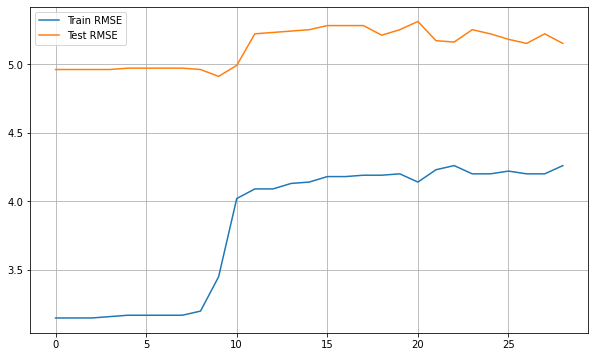

In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
m=df.shape[1]-4

for i in tqdm(range(m)):
    pca = PCA(n_components=Train_X_std.shape[1]-i)
    Train_X_std_pca = pca.fit_transform(Train_X_std)
    Test_X_std_pca = pca.fit_transform(Test_X_std)
    
    LR = LinearRegression()
    LR.fit(Train_X_std_pca, Train_Y)

    pred1 = LR.predict(Train_X_std_pca)
    pred2 = LR.predict(Test_X_std_pca)

    Trr.append(round(np.sqrt(mean_squared_error(Train_Y, pred1)),2))
    Tss.append(round(np.sqrt(mean_squared_error(Test_Y, pred2)),2))


plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')

plt.legend()
plt.grid()
plt.show()

#### Inference:
It can be seen that the performance of the models is quiet comparable upon dropping features using VIF, RFE & PCA Techniques. Comparing the RMSE plots, the optimal values were found for dropping most features using manual RFE Technique.

In [33]:
#Shortlisting the selected Features (with RFE)

lm = LinearRegression()
rfe = RFE(lm,n_features_to_select=df.shape[1]-23)           
rfe = rfe.fit(Train_X_std, Train_Y)

LR = LinearRegression()
LR.fit(Train_X_std.loc[:,rfe.support_], Train_Y)

#print(Train_X_std.loc[:,rfe.support_].columns)

pred1 = LR.predict(Train_X_std.loc[:,rfe.support_])
pred2 = LR.predict(Test_X_std.loc[:,rfe.support_])

print(np.sqrt(mean_squared_error(Train_Y, pred1)))
print(np.sqrt(mean_squared_error(Test_Y, pred2)))

Train_X_std = Train_X_std.loc[:,rfe.support_]
Test_X_std = Test_X_std.loc[:,rfe.support_]

3.1574050920050567
4.260943103114442


# 6. Predictive Modelling

In [34]:
#Let us first define a function to evaluate our models
Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([4,8]), columns=['Train-R2','Test-R2','Train-RSS','Test-RSS',
                                                                            'Train-MSE','Test-MSE','Train-RMSE','Test-RMSE'])
rc=np.random.choice(Train_X_std.loc[:,Train_X_std.nunique()>50].columns,3)
def Evaluate(n, pred1,pred2):
    #Plotting predicted predicteds alongside the actual datapoints 
    plt.figure(figsize=[15,6])
    for e,i in enumerate(rc):
        plt.subplot(2,3,e+1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
        plt.legend()
    plt.show()

    #Evaluating the model
    print('\n\n{}Training Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Training set --->',round(r2_score(Train_Y, pred1),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Train_Y-pred1)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Train_Y, pred1),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))

    print('\n{}Testing Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Testing set --->',round(r2_score(Test_Y, pred2),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Test_Y-pred2)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Test_Y, pred2),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
    print('\n{}Residual Plots{}'.format('-'*20, '-'*20))
    
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-R2']  = round(r2_score(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-R2']   = round(r2_score(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RSS'] = round(np.sum(np.square(Train_Y-pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RSS']  = round(np.sum(np.square(Test_Y-pred2)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-MSE'] = round(mean_squared_error(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-MSE']  = round(mean_squared_error(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)

    # Plotting y_test and y_pred to understand the spread.
    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    sns.distplot((Train_Y - pred1))
    plt.title('Error Terms')          
    plt.xlabel('Errors') 

    plt.subplot(1,2,2)
    plt.scatter(Train_Y,pred1)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Test vs Prediction')         
    plt.xlabel('y_test')                       
    plt.ylabel('y_pred')                       
    plt.show()



    
    
    

#### Objective:
Let us now try building multiple regression models & compare their evaluation metrics to choose the best fit model both training and testing sets...

# 6a. Multiple Linear Regression(MLR)

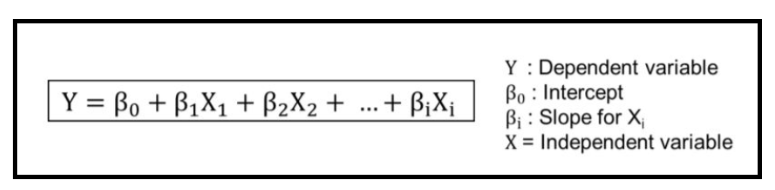

In [35]:
from IPython.display import Image
Image(filename='mlr_pic.png') 

<<<------------------------- Evaluating Multiple Linear Regression Model ------------------------->>>

The Coeffecient of the Regresion Model was found to be  [-0.2959327   2.79624236  0.14954627  0.32056788  0.39288702  0.29292169
  0.16721103  0.51302174  0.59208669  0.44813856]
The Intercept of the Regresion Model was found to be  8.547208737678247


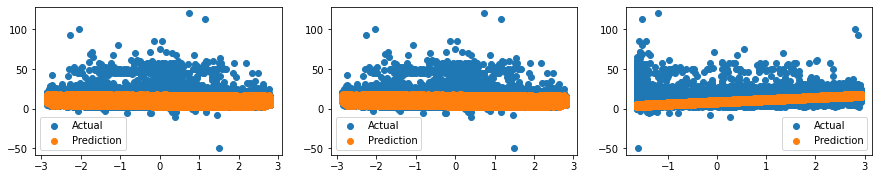



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.45956646358093645
Residual Sum of Squares (RSS) on Training set  ---> 1301589.6240318557
Mean Squared Error (MSE) on Training set       ---> 9.96920691501946
Root Mean Squared Error (RMSE) on Training set ---> 3.157405092005057

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.31647705492052136
Residual Sum of Squares (RSS) on Training set  ---> 592618.1188533471
Mean Squared Error (MSE) on Training set       ---> 18.15563612797853
Root Mean Squared Error (RMSE) on Training set ---> 4.260943103114442

--------------------Residual Plots--------------------


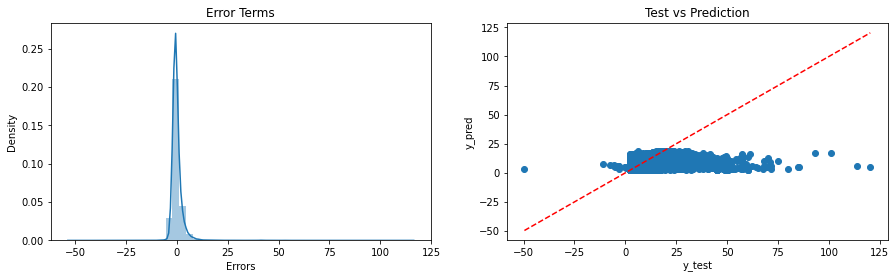

In [36]:
#Multiple Linear Regression

MLR = LinearRegression().fit(Train_X_std,Train_Y)
pred1 = MLR.predict(Train_X_std)
pred2 = MLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Multiple Linear Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(0, pred1, pred2)

# 6b. Ridge Regression Model

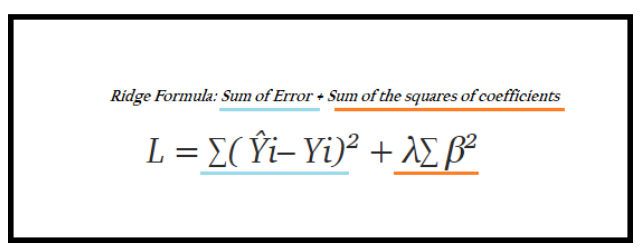

In [37]:
Image(filename='ridge_regression.png') 

<<<------------------------- Evaluating Ridge Regression Model ------------------------->>>

The Coeffecient of the Regresion Model was found to be  [-0.2959327   2.79624236  0.14954627  0.32056788  0.39288702  0.29292169
  0.16721103  0.51302174  0.59208669  0.44813856]
The Intercept of the Regresion Model was found to be  8.547208737678247


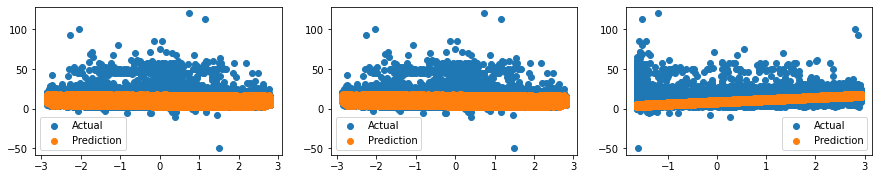



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.4595664635474455
Residual Sum of Squares (RSS) on Training set  ---> 1301589.6241125162
Mean Squared Error (MSE) on Training set       ---> 9.969206915637258
Root Mean Squared Error (RMSE) on Training set ---> 3.15740509210289

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.31647707568340455
Residual Sum of Squares (RSS) on Training set  ---> 592618.1008518143
Mean Squared Error (MSE) on Training set       ---> 18.155635576477874
Root Mean Squared Error (RMSE) on Training set ---> 4.260943038398644

--------------------Residual Plots--------------------


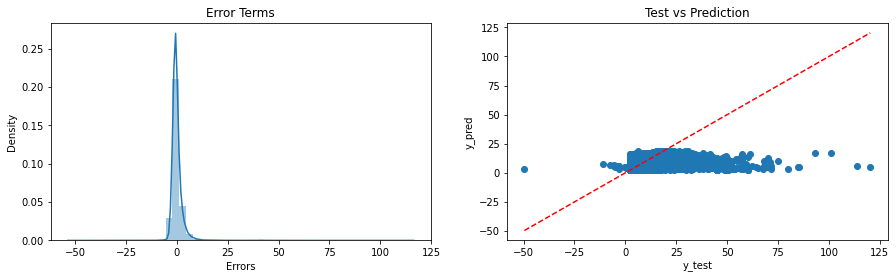

In [38]:
#Creating a Ridge Regression model

RLR = Ridge().fit(Train_X_std,Train_Y)
pred1 = RLR.predict(Train_X_std)
pred2 = RLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Ridge Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(1, pred1, pred2)


# 6c. Lasso Regression Model

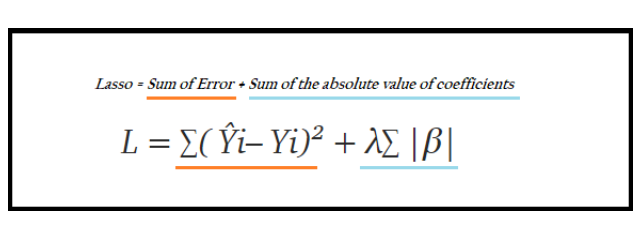

In [39]:
Image(filename='lasso_regression.png') 

<<<------------------------- Evaluating Lasso Regression Model ------------------------->>>

The Coeffecient of the Regresion Model was found to be  [-0.2959327   2.79624236  0.14954627  0.32056788  0.39288702  0.29292169
  0.16721103  0.51302174  0.59208669  0.44813856]
The Intercept of the Regresion Model was found to be  8.547208737678247


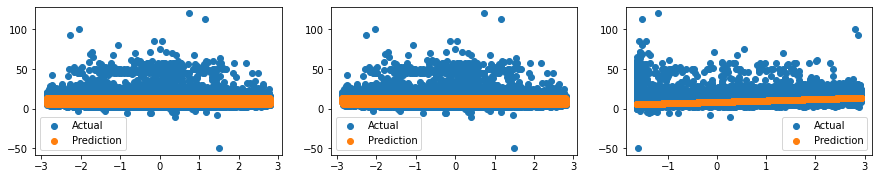



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.3633839709780333
Residual Sum of Squares (RSS) on Training set  ---> 1533237.229054621
Mean Squared Error (MSE) on Training set       ---> 11.7434550061245
Root Mean Squared Error (RMSE) on Training set ---> 3.426872481742573

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.2513098583710146
Residual Sum of Squares (RSS) on Training set  ---> 649118.4334486743
Mean Squared Error (MSE) on Training set       ---> 19.886597636367583
Root Mean Squared Error (RMSE) on Training set ---> 4.459439161639901

--------------------Residual Plots--------------------


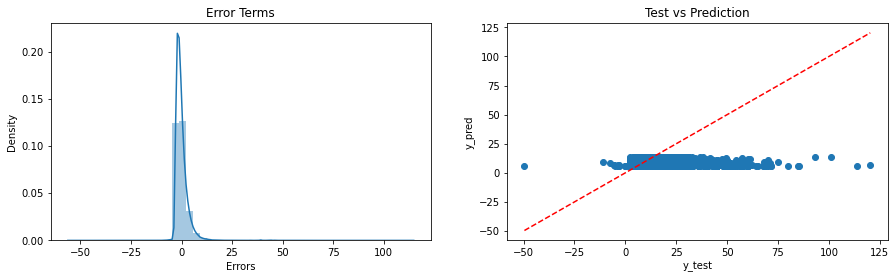

In [40]:
#Creating a Lasso Regression model

LLR = Lasso().fit(Train_X_std,Train_Y)
pred1 = LLR.predict(Train_X_std)
pred2 = LLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Lasso Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(2, pred1, pred2)

# 6d. Elastic-Net Regression

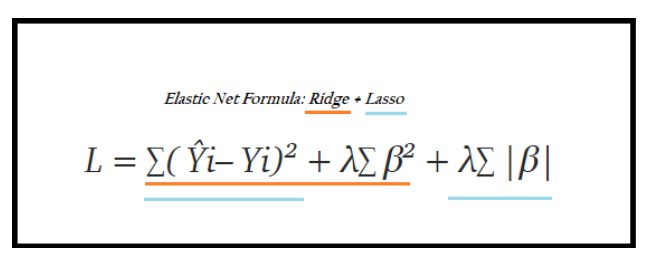

In [41]:
Image(filename='elastic_regression.png')

<<<------------------------- Evaluating Elastic-Net Regression Model ------------------------->>>

The Coeffecient of the Regresion Model was found to be  [-0.2959327   2.79624236  0.14954627  0.32056788  0.39288702  0.29292169
  0.16721103  0.51302174  0.59208669  0.44813856]
The Intercept of the Regresion Model was found to be  8.547208737678247


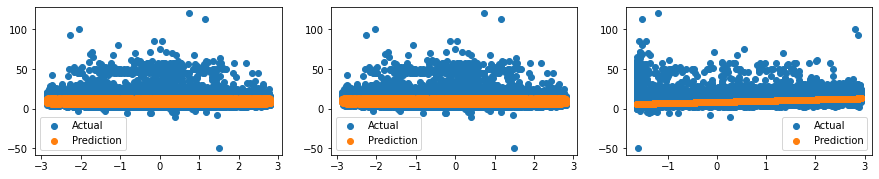



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.331736200573176
Residual Sum of Squares (RSS) on Training set  ---> 1609458.275319898
Mean Squared Error (MSE) on Training set       ---> 12.327251440475319
Root Mean Squared Error (RMSE) on Training set ---> 3.51101857592285

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.2293425857025514
Residual Sum of Squares (RSS) on Training set  ---> 668164.1785825256
Mean Squared Error (MSE) on Training set       ---> 20.470089108254207
Root Mean Squared Error (RMSE) on Training set ---> 4.5243882579034045

--------------------Residual Plots--------------------


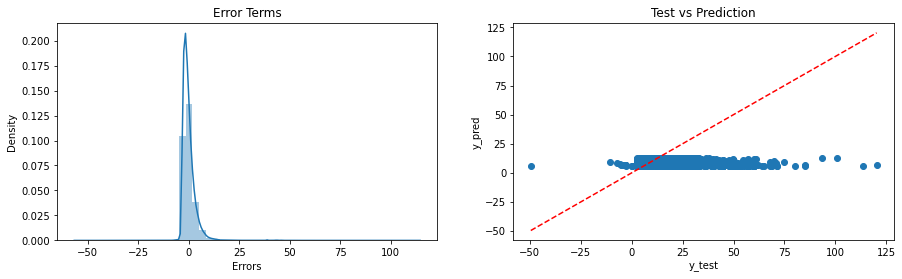

In [42]:
#Creating a ElasticNet Regression model

ENR = ElasticNet().fit(Train_X_std,Train_Y)
pred1 = ENR.predict(Train_X_std)
pred2 = ENR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Elastic-Net Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(3, pred1, pred2)

# 6e. Comparing the Evaluation Metics of the Models

In [43]:
# Regression Models Results Evaluation
EMC = Model_Evaluation_Comparison_Matrix.iloc[:4].copy()  # Exclude the 5th row
EMC.index = ['Multiple Linear Regression (MLR)', 'Ridge Linear Regression (RLR)', 'Lasso Linear Regression (LLR)', 'Elastic-Net Regression (ENR)']  # Update the index

In [44]:
EMC

,Train-R2,Test-R2,Train-RSS,Test-RSS,Train-MSE,Test-MSE,Train-RMSE,Test-RMSE
Multiple Linear Regression (MLR),0.459566,0.316477,1.301590e+06,592618.118853,9.969207,18.155636,3.157405,4.260943
Ridge Linear Regression (RLR),0.459566,0.316477,1.301590e+06,592618.100852,9.969207,18.155636,3.157405,4.260943
Lasso Linear Regression (LLR),0.363384,0.251310,1.533237e+06,649118.433449,11.743455,19.886598,3.426872,4.459439
Elastic-Net Regression (ENR),0.331736,0.229343,1.609458e+06,668164.178583,12.327251,20.470089,3.511019,4.524388


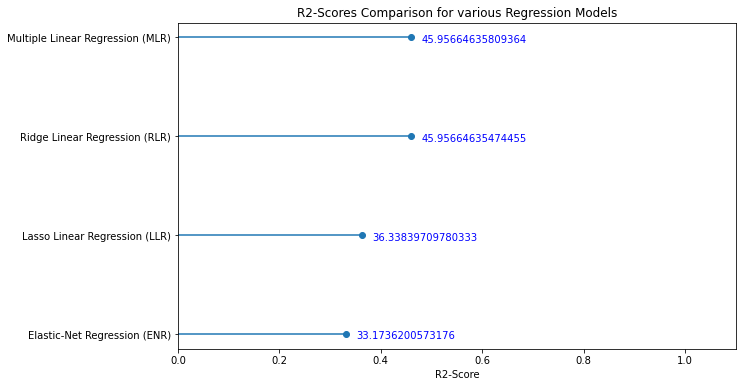

In [45]:
# R2-Scores Comparison for different Regression Models

R2 = EMC['Train-R2'].sort_values(ascending=True)
plt.hlines(y=R2.index, xmin=0, xmax=R2.values)
plt.plot(R2.values, R2.index,'o')
plt.title('R2-Scores Comparison for various Regression Models')
plt.xlabel('R2-Score')
#plt.ylabel('Regression Models')
for i, v in enumerate(R2):
    plt.text(v+0.02, i-0.05, str(v*100), color='blue')
plt.xlim([0,1.1])
plt.show()

# Inference: 
From the above plot, it is clear that the ML and RL models have the highest explainability power to understand the dataset.

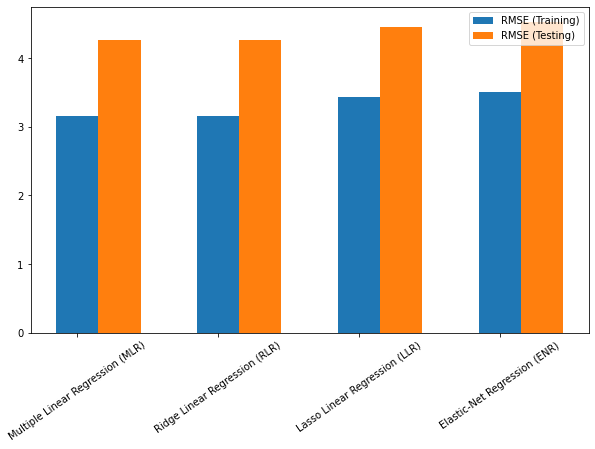

In [46]:
# Root Mean Squared Error Comparison for different Regression Models
cc = Model_Evaluation_Comparison_Matrix.columns.values
plt.bar(np.arange(4), Model_Evaluation_Comparison_Matrix[cc[6]].values[:4], width=0.3, label='RMSE (Training)')
plt.bar(np.arange(4)+0.3, Model_Evaluation_Comparison_Matrix[cc[7]].values[:4], width=0.3, label='RMSE (Testing)')
plt.xticks(np.arange(4), EMC.index[:4], rotation=35)
plt.legend()
plt.show()


# 7. Project Outcomes & Conclusions

#### Here are some of the key outcomes of the project:

The Dataset was large enough totalling 2M samples & after preprocessing 18.4% of the datasamples were dropped.

Visualising the distribution of data & their relationships, helped us to get some insights on the feature-set.

The features had high multicollinearity, hence in Feature Extraction step, we shortlisted the appropriate features with VIF Technique.

Testing multiple algorithms with default hyperparamters gave us some understanding for various models performance on this specific dataset.

While, MLR,RLR was the best choise,  as their scores were quiet comparable & also they're more generalisable.